Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#import os
#os.chdir('/content/drive/My Drive/Dataset_LUNA_16')
#os.path.exists('/content/drive/My Drive/Dataset_LUNA_16')

Mounted at /content/gdrive


In [ ]:
#!pip install tensorflow
import tensorflow
print(tensorflow.__version__)
#!pip install tensorflow==1.15.3

2.15.0


In [ ]:
#!apt-get -qq install -y Pillow
#!python -m pip install scipy==1.1.0
import PIL
import scipy
print(PIL.__version__)
print(scipy.__version__)


9.4.0
1.11.4


In [ ]:
!pip install SimpleITK
import SimpleITK
print(SimpleITK.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.9 MB/s eta 0:00:00
2.3.1


In [ ]:
#Import library

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

import SimpleITK as sitk

from PIL import Image
import imageio # thay thế cho "imread" của thư viên scipy
#from scipy.misc import imread

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

In [ ]:
# DATA
annotations = pd.read_csv('/content/gdrive/My Drive/Dataset_LUNA_16/annotations.csv')
candidates = pd.read_csv('/content/gdrive/My Drive/Dataset_LUNA_16/candidates.csv')

In [ ]:
annotations.head() #ghi chú về các vùng ung thư thực tế trong ảnh. ==> Dùng để đánh giá hiệu suất mô hình

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [ ]:
candidates.head() # Tập data cho biết vị trí tọa độ, vùng có thể bị ung thư phổi, Tập này sẽ sử dụng để train model

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


In [ ]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  551065 non-null  object 
 1   coordX     551065 non-null  float64
 2   coordY     551065 non-null  float64
 3   coordZ     551065 non-null  float64
 4   class      551065 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [ ]:
print("Tổng số vùng có khả năng là ung thư: ",len(candidates[candidates['class'] == 1]))
print("Tổng số vùng không có ung thư: ",len(candidates[candidates['class'] == 0]))

Tổng số vùng có khả năng là ung thư:  1351
Tổng số vùng không có ung thư:  549714


In [ ]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

2


In [ ]:
# CTScan xử lý ảnh CT scan (Chụp cắt lớp vi tính)
'''
filename: Lưu trữ tên file của ảnh CT scan.
coords: Lưu trữ tọa độ (coordinates) của một điểm quan tâm trong ảnh.
ds: Lưu trữ dữ liệu ảnh CT được đọc bằng thư viện SimpleITK (SITK).
image: Lưu trữ mảng NumPy chứa dữ liệu ảnh CT đã được đọc. '''
class CTScan(object):
    def __init__(self, filename = None, coords = None): # self dùng để trỏ đến đối tượng của hàm đó
        self.filename = filename                        # filename dùng để lưu trữ tên file CT scan => gán None nên ko có giá trị nào truyền vào
        self.coords = coords                            # tham số kiểu list hoặc tuple, lưu trữ tọa độ (coordinates) của một điểm trong ảnh CT.=> gán None nên ko có giá trị nào truyền vào
        self.ds = None                                  # self.ds được dùng để lưu trữ dữ liệu ảnh CT dưới dạng dữ liệu của thư viện SimpleITK (SITK).
        self.image = None                               # self.image được dùng để lưu trữ mảng NumPy chứa dữ liệu ảnh CT đã được đọc.
                                                        # => Hàm __init__ có nhiệm vụ thiết lập các thuộc tính ban đầu cho một đối tượng CTScan mới.
        if filename is not None:
            self.read_mhd_image()

    def reset_coords(self, coords):                     # Hàm reset_coords thay đổi tọa độ điểm trong đối tượng CTScan. # coords nằm trong file candidates X = -56.08 , Y = -67.85 , Z = -311.92
        self.coords = coords                            # thay đổi tọa độ coords trước đó

    def read_mhd_image(self):
        path = glob.glob('/content/gdrive/My Drive/Dataset_LUNA_16/seg-lungs-LUNA16/*/'+ self.filename + '.mhd') # File MHD (Medical Imaging Header) | thư viện glob để tìm kiếm các file có tên khớp với mẫu
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)    # trích xuất mảng NumPy chứa dữ liệu ảnh từ đối tượng SITK self.ds và lưu vào thuộc tính self.image.

    def get_resolution(self):                           #  lấy độ phân giải của ảnh CT scan, lưu trữ thông tin về khoảng cách giữa các pixel trong không gian 3 chiều vào ds
        return self.ds.GetSpacing()                     # self.ds.GetSpacing(): Trả về khoảng cách pixel theo từng chiều.#(0,64453125, 0,64453125, 1,7999999523162842)

    def get_origin(self):                               #để lấy thông tin về điểm gốc của hệ tọa độ.
        return self.ds.GetOrigin()                      # self.ds.GetOrigin(): Trả về vị trí của góc voxel đầu tiên trong không gian 3D. Lưu trữ Offset = -157.67773 -311.67773 -438.39999999999998

    def get_ds(self):
        print(self.ds)
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords) # Trả về một dạng tọa độ mới (X, Y, Z)

    def get_image(self):                                   #Trả về mảng NumPy chứa dữ liệu ảnh CT.
        return self.image

    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords() # tọa độ mới sau đã được tính
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage

    def normalizePlanes(self, npzarray):                   #Nó chuẩn hóa các giá trị pixel trong CT để chúng nằm trong phạm vi từ 0 đến 1.
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray

    def save_image(self, filename, width):                 #Lưu một phần của hình ảnh CT đã được chuẩn hóa vào một file hình ảnh, có định dạng được chỉ định bởi filename.
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

In [ ]:
import matplotlib.pyplot as plt

positives = candidates[candidates['class']==1].index
negatives = candidates[candidates['class']==0].index



In [ ]:
# print(np.asarray(candidates.iloc[negatives[600]])[0], \
              # np.asarray(candidates.iloc[negatives[600]])[1:-1])
def get_scan_info(scan):
    x, y, z = scan.get_voxel_coords()
    image = scan.get_image()
    file_scan = scan.get_ds()
    dx, dy, dz = scan.get_resolution()
    x0, y0, z0 = scan.get_origin()
    read_scan = scan.read_mhd_image()
    # normalize_pic = scan.normalizePlanes()

    # In các giá trị bên trong hàm
    print("\n")
    print("Voxel coordinates:")
    print("x =", x)
    print("y =", y)
    print("z =", z)

    print("Resolution:")
    print("dx =", dx)
    print("dy =", dy)
    print("dz =", dz)

    print("Origin:")
    print("x0 =", x0)
    print("y0 =", y0)
    print("z0 =", z0)

    print("\n")
    #print(normalize_pic)
    print(image.shape) # 194,512,512
    #plt.imshow(image)
    #plt.show()

    print("\n")
    print("file_scan:", file_scan)

# Gọi hàm
scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])          #lấy
scan.read_mhd_image()
get_scan_info(scan)

Image (0x5730b6934170)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 2095
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 2065
  UpdateMTime: 2091
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 194]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 194]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 194]
  Spacing: [0.644531, 0.644531, 1.8]
  Origin: [-157.678, -311.678, -438.4]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.644531 0 0
0 0.644531 0
0 0 1.8

  PointToIndexMatrix: 
1.55152 0 0
0 1.55152 0
0 0 0.555556

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x5730b675d640)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, shor

In [ ]:

scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])          #lấy
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()


In [ ]:
##Đọc dữ liệu từ tệp MHD được chỉ định, xác định tọa độ và thuộc tính (tọa độ gốc, độ phân giải) của ảnh CT đã được đọc.
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68) #[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()



In [ ]:
#positives chứa một Index chứa các chỉ mục của các mẫu dương tính trong candidates -> 1351 mẫu dương tính

positives

Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,   3287,
         3289,
       ...
       545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334, 550810,
       550906],
      dtype='int64', length=1351)

In [ ]:

np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

#negatives: Là một Index chứa các chỉ mục của các mẫu âm tính trong DataFrame candidates
#len(positives)*5: Là số lượng chỉ mục muốn chọn, trong trường hợp này là 5 lần kích thước của tập hợp positives.
#replace=False: Đảm bảo rằng mỗi chỉ mục được chọn chỉ xuất hiện một lần trong tập hợp mới, không có lấy mẫu trùng lặp.
#negIndexes, một mảng chứa các chỉ mục được chọn ngẫu nhiên từ negatives có kích thước gấp 5 lần kích thước của positives.

In [ ]:
#candidatesDf có 8106 hàng và 5 cột, gồm cả mẫu pos và mẫu neg, được chọn ngẫu nhiên để tạo ra một tập dữ liệu cân bằng về số lượng giữa hai lớp.
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]
print(candidatesDf)

                                                seriesuid      coordX  \
13      1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  104.164804   
78      1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.940000   
1303    1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   70.190000   
3050    1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   89.320000   
3052    1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   94.930000   
...                                                   ...         ...   
179890  1.3.6.1.4.1.14519.5.2.1.6279.6001.198698492013... -111.329211   
478391  1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947...  -98.890000   
104437  1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677...   35.347896   
53212   1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048...   60.276636   
9679    1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  -52.346900   

            coordY      coordZ  class  
13     -211.685591 -227.011364      1  
78     -175.040000 -297.870000      1  
130

In [ ]:
# 64% dữ liệu dùng cho tập train. (80% của X_train)
# 16% dữ liệu dùng cho tập val. (20% của X_train)
# 20% dữ liệu dùng cho tập test. (20% của X)

from sklearn.model_selection import train_test_split

X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [ ]:
X_train.to_pickle('/content/gdrive/My Drive/Dataset_LUNA_16/preprocessed_data/traindata')
X_test.to_pickle('/content/gdrive/My Drive/Dataset_LUNA_16/preprocessed_data/testdata')
X_val.to_pickle('/content/gdrive/My Drive/Dataset_LUNA_16/preprocessed_data/valdata')

In [ ]:
# Thông tin ground true của case dương tính tại tập train
print('Số case ung thư: ' + str(y_train.sum())) # các trường hợp ung thư, class == 1
print('Tổng train set ' + str(len(y_train)))
print('Case dương tính chiếm (%) ' + str(y_train.sum()*1.0/len(y_train)))

Số case ung thư: 845
Tổng train set 5187
Case dương tính chiếm (%) 0.16290726817042606


In [ ]:
# tempDf sẽ chứa toàn bộ nhãn dương tính (class 1) từ X_train. Vậy có 845 case ung thư trong tập train
tempDf = X_train[y_train == 1]
print(tempDf)


                                                seriesuid      coordX  \
147683  1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133...  -50.320000   
468235  1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853...   59.055160   
66326   1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852...   85.220000   
222488  1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224...   99.314664   
30517   1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261... -116.347267   
...                                                   ...         ...   
436163  1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286...   88.955096   
13078   1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...  -57.089458   
352132  1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547...  100.136716   
188812  1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895...  118.180000   
459476  1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263... -112.420630   

            coordY       coordZ  
147683   88.020000  -677.090000  
468235  -25.035106  -196.733664  
66326  -206.430000   

In [ ]:
#TĂNG CƯỜNG DỮ LIỆU POS (DUPLICATE DATA POS)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
# tempDf thành các chỉ mục mới bằng cách thêm một số lớn (1 triệu) vào chỉ mục hiện có của các mẫu dương tính. Điều này đảm bảo rằng index của các hàng mới không trùng lặp với các index hiện có của trainset.
X_train_new = pd.concat([X_train, tempDf])  #tập train mới


tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = pd.concat([X_train_new, tempDf])

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000) #ytemp là chỉ định lại index mãu pos với các index mới từ bước 1.
ytemp.loc[:] = 1 # thiết lập tất cả các giá trị trong ytemp thành 1 (pos)
y_train_new = pd.concat([y_train, ytemp])

ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = pd.concat([y_train_new, ytemp])

print(len(X_train_new), len(y_train_new)) #Tập train mới + kích thước mới: thêm 2 lần hình pos vào tập train

print((y_train_new == 1).sum())

6877 6877
2535


In [ ]:
import scipy.misc
import cv2

In [ ]:
#from scipy.misc import imresize
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image

#chuẩn hóa hình ảnh để có giá trị trung bình gần bằng 0.
#chia mỗi pixel cho 255 (khoảng từ 0 đến 1), trừ đi giá trị trung bình (-0.25) và cuối cùng nhân lại với 255 để đưa giá trị về khoảng từ 0 đến 255
    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image

#giảm kích thước của hình ảnh xuống cỡ 40x40 pixel bằng cách sử dụng phép interpolation để giảm kích thước của hình ảnh, giảm thiểu độ phức tạp tính toán và tăng tốc độ huấn luyện.
    def downsample_data(self):
        self.image = cv2.resize(self.image, (40,40), interpolation = cv2.INTER_AREA)
        return self.image

#tăng kích thước của hình ảnh lên cỡ 224x224 pixel bằng cách sử dụng phép interpolation để nâng cao độ phân giải của hình ảnh, giúp model có thể phát hiện và nhận dạng đặc điểm nhỏ hơn trong hình ảnh.
    def upsample_data(self):
        self.image = cv2.resize(self.image, (224, 224), interpolation = cv2.INTER_CUBIC)
        return self.image

    '''def rbg_correction(self):
      self.image = Image.fromarray(self.image)
      if self.image.mode != 'RGB':
            self.image = self.image.convert('RGB')
      return self.image'''

Original shape of input image:  (50, 50, 3)


"inp5 = Pp.rbg_correction()\nplt.subplot(225)\nplt.imshow(inp5,cmap='gray')\nplt.grid(False)"

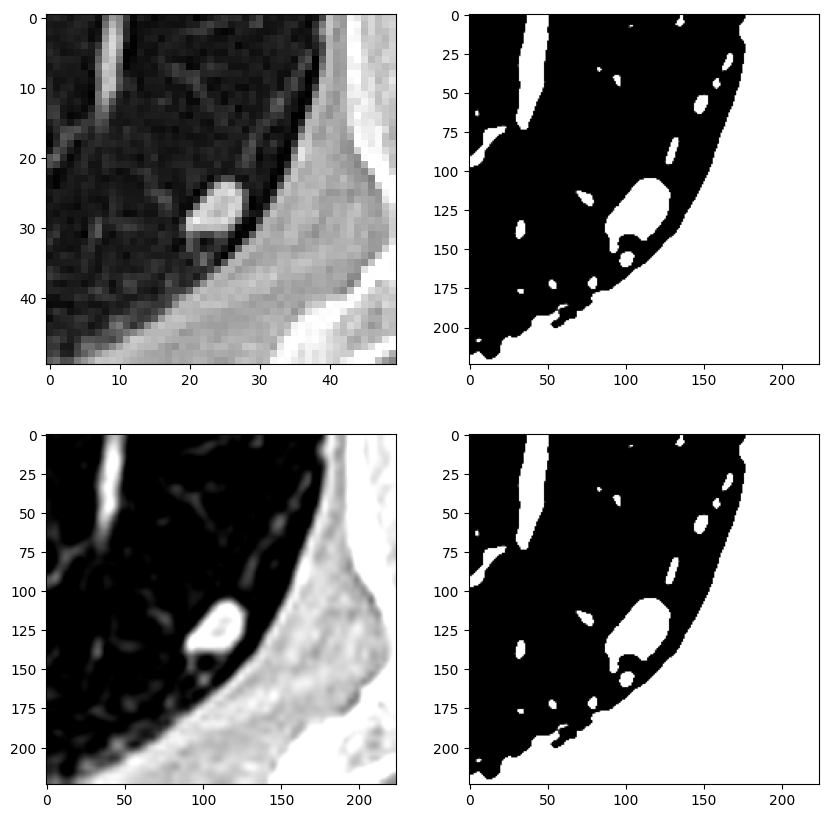

In [ ]:
dirName = '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/'
plt.figure(figsize = (10,10))

inp = cv2.imread(dirName + 'image_'+ str(517334) + '.jpg') # thay đổi hình trong hàm str(30517)
print ("Original shape of input image: ", inp.shape)
plt.subplot(221)    #plot hình gốc với shape 50,50,3
plt.imshow(inp, cmap='gray')
plt.grid(False)

inp = PreProcessing(inp).upsample_data() #tăng size lên để chuẩn bị preprocess
Pp = PreProcessing(inp)

inp2 = Pp.subtract_mean()  #chuẩn hóa hình ảnh.
plt.subplot(222)
plt.imshow(inp2, cmap='gray')
plt.grid(False)

inp3 = ImageEnhance.Contrast(Image.fromarray(inp)) # tạo đối tượng ImageEnhance.Contrast
contrast = 1.5
inp3 = inp3.enhance(contrast) # tăng độ tương phản của hình ảnh
plt.subplot(223)
plt.imshow(inp3, cmap='gray')
plt.grid(False)

inp4 = Pp.upsample_data() #down size để giảm độ phức tạp
plt.subplot(224)
plt.imshow(inp4,cmap='gray')
plt.grid(False)


'''inp5 = Pp.rbg_correction()
plt.subplot(225)
plt.imshow(inp5,cmap='gray')
plt.grid(False)'''

In [ ]:
y_train_new.values.astype(int) #chuyển nhãn thành số nguyên

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_'+str(x)+'.jpg') #  len = 6877

In [ ]:
#@title Default title text
dataset_file = 'traindatalabels.txt'
filenames = train_filenames.values.astype(str)
train_filenames =X_train_new.index.to_series().apply(lambda x:filenames) # gán index tương ứng với tên từng file hình trong traindatalabels.txt  (len = 6877)
labels = y_train_new.values.astype(int) # các label của tập dữ liệu pos và neg (1,0)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [ ]:
# Load HDF5 dataset
import h5py
h5f = h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/traindataset.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/valdataset.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']

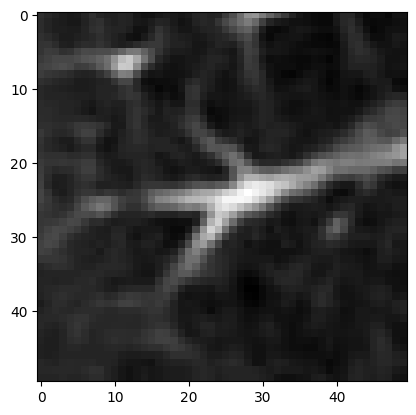

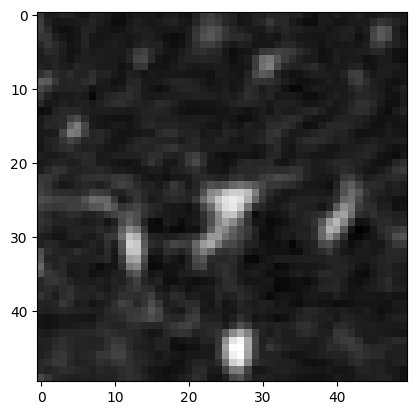

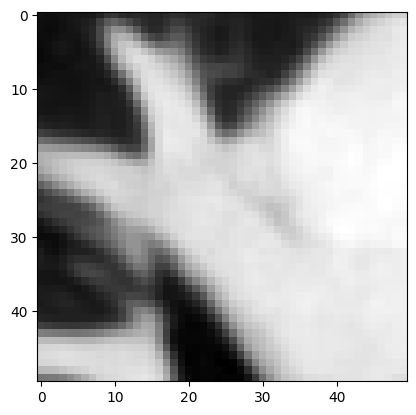

In [ ]:
# Mở tệp HDF5
with h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/traindataset.h5', 'r') as f:

    # Truy cập vào dữ liệu X
    X = f["X"]

    # Hiển thị 5 mẫu đầu tiên
    for i in range(3):
        plt.imshow(X[i], cmap='gray')
        plt.show()
        # print(X[i]) # mỗi phần tử có shape là 50 row, 50 col



In [ ]:
print(pd.DataFrame(Y_train_labels))

        0    1
0     1.0  0.0
1     1.0  0.0
2     1.0  0.0
3     1.0  0.0
4     1.0  0.0
...   ...  ...
5182  1.0  0.0
5183  1.0  0.0
5184  0.0  1.0
5185  1.0  0.0
5186  1.0  0.0

[5187 rows x 2 columns]


In [ ]:
X_train_processing = np.array(X_train_images)
X_val_processing = np.array(X_val_images)


print(X_train_processing.shape,X_train_processing.dtype )
print(X_val_processing.shape,X_val_processing.dtype )

(5187, 50, 50) float32
(1297, 50, 50) float32


In [ ]:
img_test = X_train_processing[1000]
img_test_downsampled = PreProcessing(img_test).downsample_data()
img_test_upsampled = PreProcessing(img_test).upsample_data()

In [ ]:

print(Y_train_labels[1000])


[1. 0.]


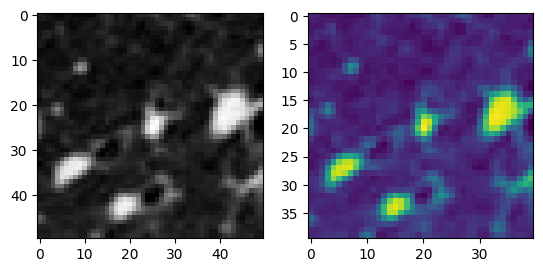

In [ ]:

plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_downsampled) #,cmap='gray'

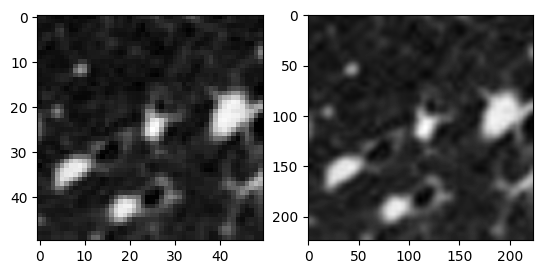

In [ ]:

plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_upsampled,cmap='gray')


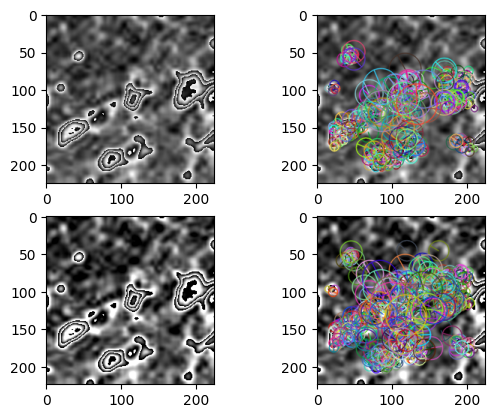

In [ ]:
# TÌm hiểu về BRISK
import cv2
brisk = cv2.BRISK_create(50)
img_BRISK_1 = img_test_upsampled.copy()
rgb = cv2.cvtColor(img_BRISK_1, cv2.COLOR_GRAY2RGB)
img_BRISK_2 = rgb*1000
img_BRISK_3 = np.array(img_BRISK_2, dtype=np.uint8)
img_contr_copy = img_BRISK_3.copy()

plt.subplot(221)
plt.imshow(img_BRISK_3, cmap='gray')
kpts_1, des_1 = brisk.detectAndCompute(img_BRISK_3, None)

image_BRISK_1 = cv2.drawKeypoints(image=img_BRISK_3, outImage=img_BRISK_3, keypoints=kpts_1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(222)
plt.imshow(image_BRISK_1, cmap='gray')


# with enhanced contrast

inp_contr = ImageEnhance.Contrast(Image.fromarray(img_contr_copy))
contrast = 1.5
img_contr = inp_contr.enhance(contrast)
plt.subplot(223)
plt.imshow(img_contr, cmap='gray')
img_BRISK_4 = np.array(img_contr)
kpts_2, des_2 = brisk.detectAndCompute(img_BRISK_4, None)

image_BRISK_2 = cv2.drawKeypoints(image=img_BRISK_4, outImage=img_BRISK_4, keypoints=kpts_2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(224)
plt.imshow(image_BRISK_2, cmap='gray')


In [ ]:
print(image_BRISK_2.shape)

(224, 224, 3)


In [ ]:
# Converting to training dataset
X_train_images_np = np.expand_dims(np.array(X_train_images), axis = 3)
y_train_labels_np = np.array(Y_train_labels)
X_val_images_np = np.expand_dims(np.array(X_val_images), axis = 3)
y_val_labels_np = np.array(Y_val_labels)



In [ ]:
print(X_train_images_np.shape)
print(y_train_labels_np.shape)
print(X_val_images_np.shape)
print(y_val_labels_np.shape)
print("\ntype of new data:")
print(X_train_images_np.dtype)
print(y_train_labels_np.dtype)
print(X_val_images_np.dtype)
print(y_val_labels_np.dtype)

(5187, 50, 50, 1)
(5187, 2)
(1297, 50, 50, 1)
(1297, 2)

type of new data:
float32
float32
float32
float32


processing for test dataset

In [ ]:
h5f2 = h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/testdataset.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']


In [ ]:
X_test_images_np = np.expand_dims(np.array(X_test_images), axis = 3)
y_test_labels_np = np.array(Y_test_labels)

In [ ]:
#print(X_test_images_np.shape,"Type Data: ",X_test_images_np.dtype)
print(y_test_labels_np,"Type Data: ",y_test_labels_np.dtype)
print(pd.DataFrame(y_test_labels_np))
count_10 = np.sum(np.all(y_test_labels_np == [1., 0.], axis=1))
count_01 = np.sum(np.all(y_test_labels_np == [0., 1.], axis=1))
print(count_10)
print(count_01)
#pd.DataFrame(y_test_labels_np).describe()
#count_ones = np.sum(y_test_labels_np == 1)
#print(count_ones)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]] Type Data:  float32
        0    1
0     1.0  0.0
1     1.0  0.0
2     1.0  0.0
3     0.0  1.0
4     1.0  0.0
...   ...  ...
1617  1.0  0.0
1618  1.0  0.0
1619  1.0  0.0
1620  1.0  0.0
1621  1.0  0.0

[1622 rows x 2 columns]
1340
282


#Mobile.Net Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,AveragePooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from keras.layers import Input, Flatten, Dropout, Dense
from keras import regularizers
from keras.models import Model
import numpy as np
import warnings
import keras

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
# from keras.utils import layer_utils
# from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
#from keras_applications.imagenet_utils import _obtain_input_shape
#from keras.engine.topology import get_source_inputs

import os
import numpy as np
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# import scikitplot
from sklearn.metrics import roc_curve, auc

In [ ]:
import matplotlib.pyplot as plt
def summarize_diagnostics(hist):
	plt.plot(hist.history["accuracy"])
	plt.plot(hist.history['val_accuracy'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("model accuracy")
	plt.ylabel("Accuracy")
	plt.xlabel("Epoch")
	plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

## Define Model

In [ ]:
from tensorflow.keras.applications import EfficientNetB0


# initialize the training data augmentation object
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

def EfficientNetB0_Model():
  # load the VGG16 network, ensuring the head FC layer sets are left off
  baseModel = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(50, 50, 3))
  # construct the head of the model that will be placed on top of the the base model
  model = Sequential()
  model.add(Conv2D(3, (3, 3), activation='relu', padding='same', input_shape=(50, 50, 1)))
  model.add(baseModel)
  model.add(BatchNormalization())
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024, activation="relu",kernel_regularizer=regularizers.l2(0.0005)))
  model.add(Dense(512, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout (0.5))
  model.add(Dense(2, activation="softmax"))

  # place the head FC model on top of the base model (this will become the actual model we will train)
  #model = tf.keras.Model(inputs=baseModel.input)
  # loop over all layers in the base model and freeze them so they will not be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  return model
Efficient_model = EfficientNetB0_Model()
# compile our model
print("[INFO] compiling model...")
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 0.0001
EPOCHS = 50
BATCHSIZE = 32
#optimizer = tf.keras.optimizers.Adam(lr=INIT_LR)
Efficient_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
print(Efficient_model.summary())

16705208/16705208 [==============================] - 1s 0us/step
[INFO] compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 3)         30        
                                                                 
 efficientnetb0 (Functional  (None, 2, 2, 1280)        4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2, 2, 1280)        5120      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (N

In [ ]:
"""modelPath = './saved Models/dataset 02/Pretrained MobileNetV2'
if not os.path.exists(modelPath):
  os.makedirs(modelPath)
  print('Model Directory Created')
else:
  print('Model Directory Already Exists')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(modelPath+'/mobilenetv2-best-model.h5', monitor='val_categorical_accuracy',
                                                      verbose=1, save_best_only=True, mode='auto')
"""
STEP_TRAIN = len(X_train_images_np) // BATCHSIZE
STEP_TEST = len(X_test_images_np) // BATCHSIZE
modelHistory = Efficient_model.fit(train_aug.flow(X_train_images_np, y_train_labels_np, batch_size=BATCHSIZE), epochs=EPOCHS, verbose=1,
                         validation_data=(X_val_images_np, y_val_labels_np), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_TEST)
"""tf.keras.models.save_model(Efficient_model, modelPath+'/mobilenetv2-model.h5', overwrite=True, include_optimizer=True, save_format=None,
                           signatures=None, options=None)"""

Epoch 1/50
162/162 [==============================] - 52s 136ms/step - loss: 0.9672 - accuracy: 0.8295 - auc: 0.8325 - val_loss: 0.8848 - val_accuracy: 0.8273 - val_auc: 0.8316
Epoch 2/50
162/162 [==============================] - 9s 54ms/step - loss: 0.6739 - accuracy: 0.8369 - auc: 0.8372 - val_loss: 0.6707 - val_accuracy: 0.8273 - val_auc: 0.8803
Epoch 3/50
162/162 [==============================] - 7s 41ms/step - loss: 0.5443 - accuracy: 0.8367 - auc: 0.8503 - val_loss: 0.5683 - val_accuracy: 0.8273 - val_auc: 0.8939
Epoch 4/50
162/162 [==============================] - 9s 55ms/step - loss: 0.4913 - accuracy: 0.8363 - auc: 0.8590 - val_loss: 0.4643 - val_accuracy: 0.8273 - val_auc: 0.8936
Epoch 5/50
162/162 [==============================] - 7s 40ms/step - loss: 0.4483 - accuracy: 0.8369 - auc: 0.8828 - val_loss: 0.4223 - val_accuracy: 0.8273 - val_auc: 0.9040
Epoch 6/50
162/162 [==============================] - 9s 55ms/step - loss: 0.4332 - accuracy: 0.8374 - auc: 0.8936 - val_lo

"tf.keras.models.save_model(Efficient_model, modelPath+'/mobilenetv2-model.h5', overwrite=True, include_optimizer=True, save_format=None,\n                           signatures=None, options=None)"

In [ ]:
import matplotlib.pyplot as plt
def summarize_diagnostics(hist):
	plt.plot(hist.history["accuracy"])
	plt.plot(hist.history['val_accuracy'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("model accuracy")
	plt.ylabel("Accuracy")
	plt.xlabel("Epoch")
	plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

callbacks = [
    keras.callbacks.ModelCheckpoint('classification_deep_conv_model.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # Add Early Stopping
]


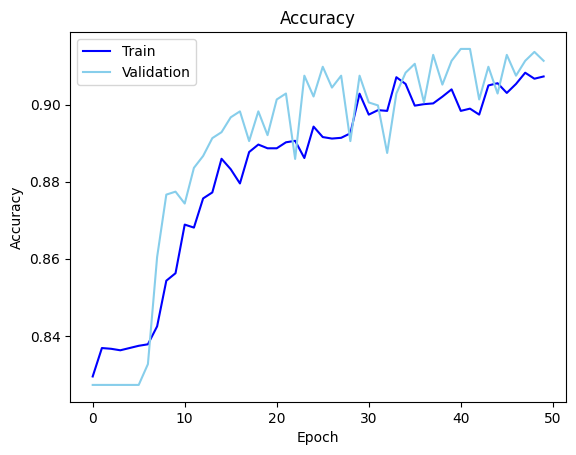

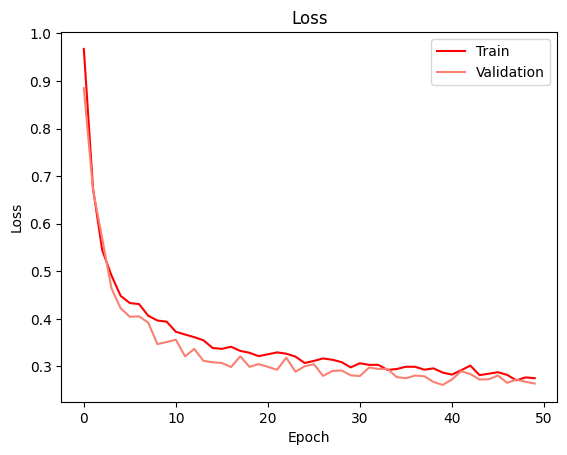

In [ ]:
#PLOT SO SÁNH GIỮA RMSPROP VÀ ADAM
plt.plot(modelHistory.history['accuracy'], label='Train', color='blue')
plt.plot(modelHistory.history['val_accuracy'], label='Validation', color='skyblue')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(modelHistory.history['loss'], label='Train', color='red')
plt.plot(modelHistory.history['val_loss'], label= 'Validation', color='salmon')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
Efficient_model.save("Efficient_model.h5")
Efficient_model.save_weights("Efficient_model.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 5s 29ms/step


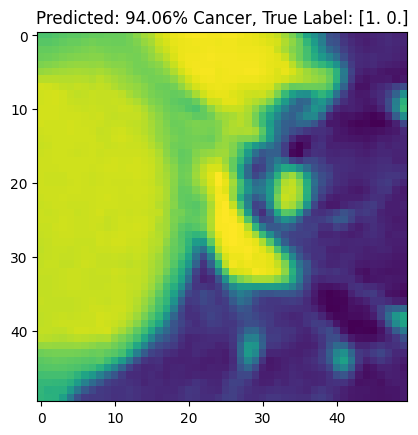

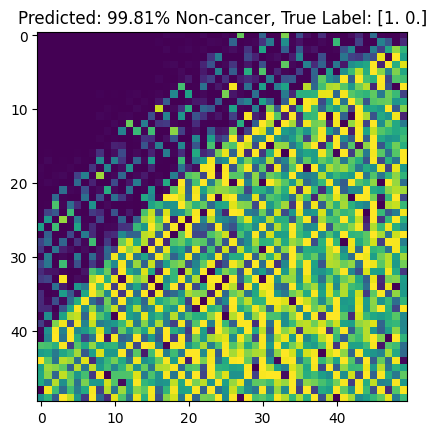

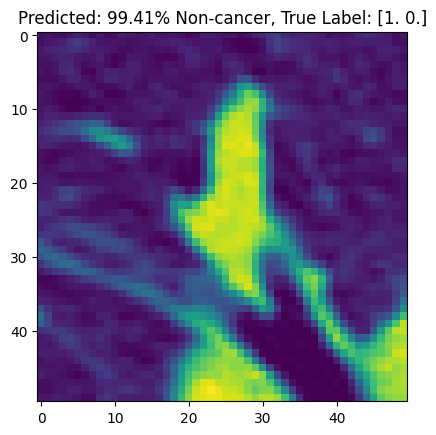

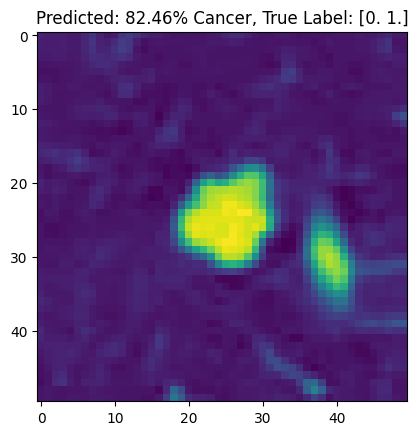

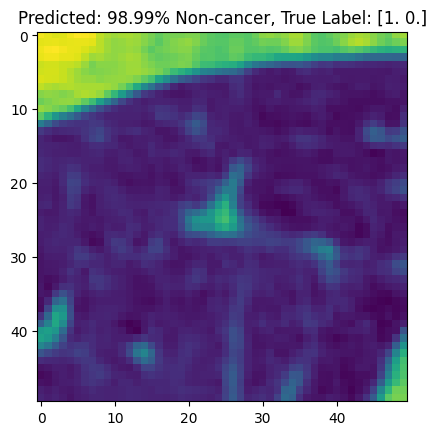

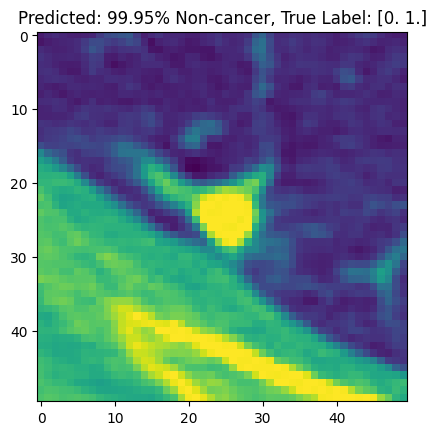

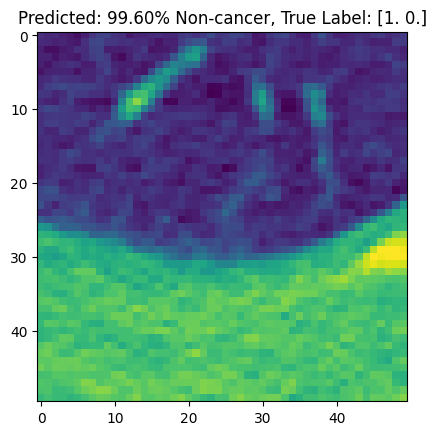

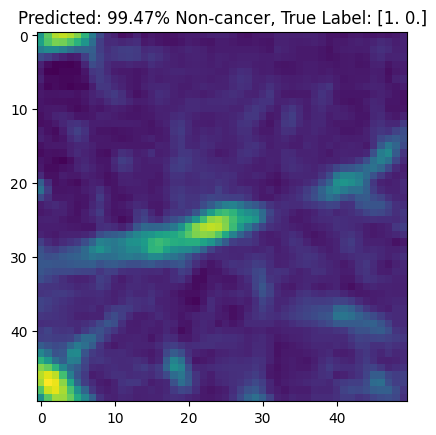

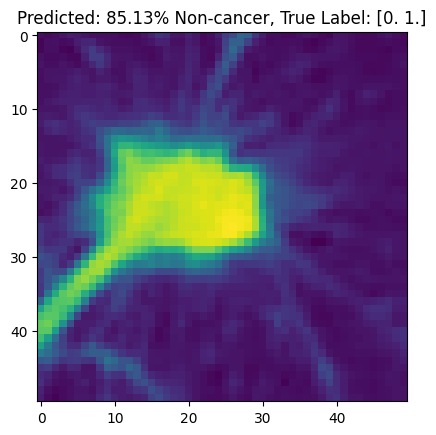

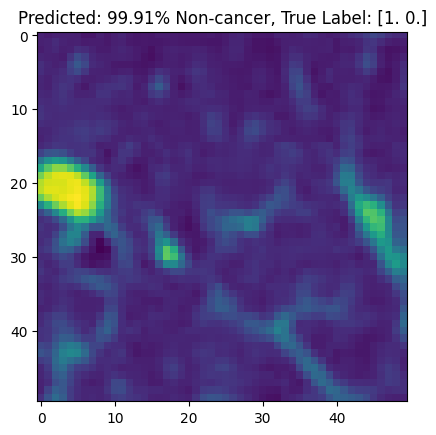

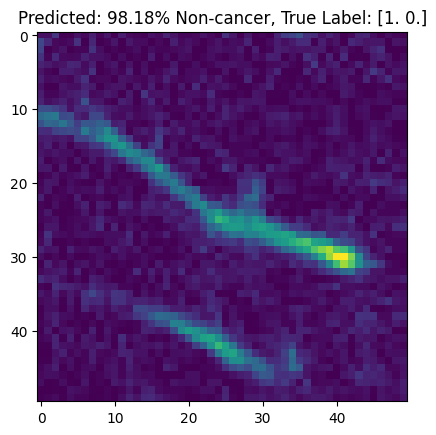

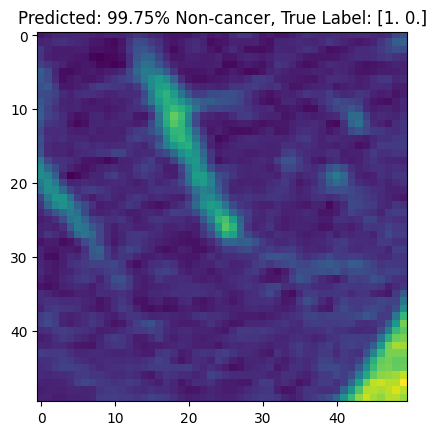

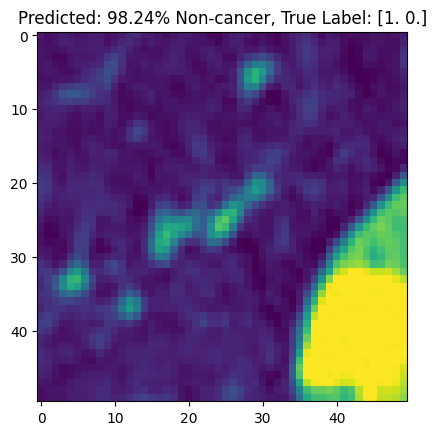

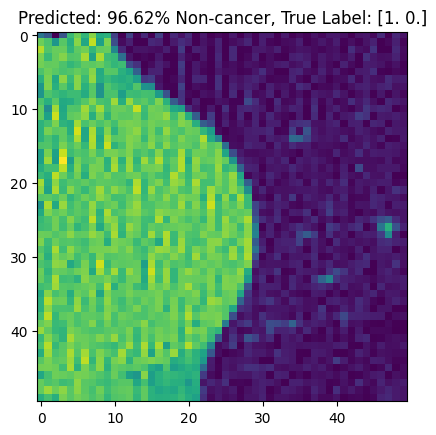

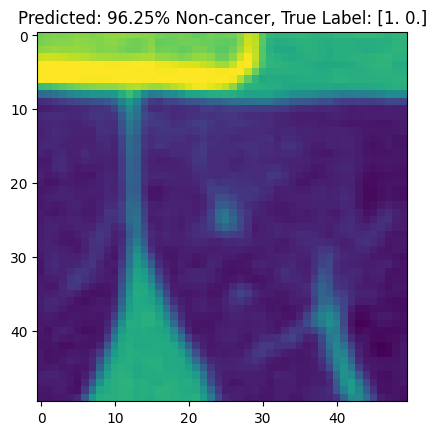

In [ ]:
Efficient_model_pred = Efficient_model.predict(X_test_images_np,batch_size = 32)
Efficient_prediction=Efficient_model_pred[5:20]
for index, probability in enumerate(Efficient_prediction):
    if probability[1] > 0.5:
        plt.title('Predicted: %.2f%% Cancer, True Label: %s' % (probability[1]*100, y_test_labels_np[index]))
    else:
        plt.title('Predicted: %.2f%% Non-cancer, True Label: %s' % ((1-probability[1])*100, y_test_labels_np[index]))
    plt.imshow(X_test_images_np[index])
    plt.show()

In [ ]:
y_pred =Efficient_model.predict(X_test_images_np,batch_size = 32)


51/51 [==============================] - 1s 25ms/step


Confusion Matrix without Normalization


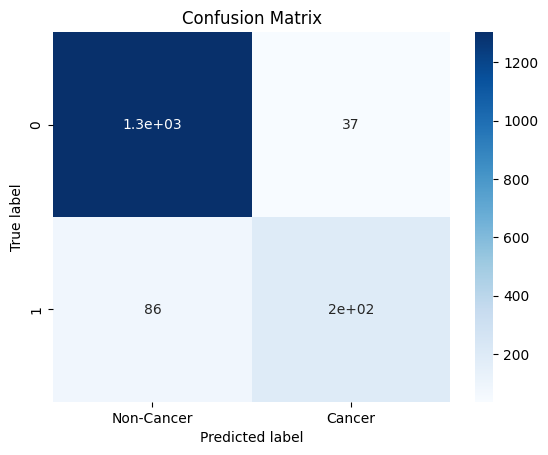

Confusion Matrix with Normalized Values


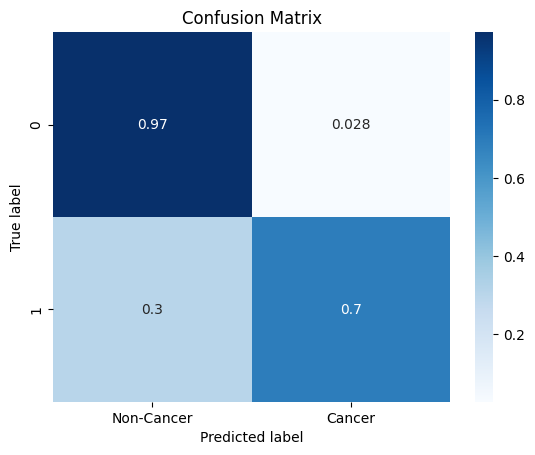

In [ ]:
Efficient_y_pred_bin = np.argmax(y_pred,axis=1)
Efficient_y_test_bin = np.argmax(y_test_labels_np,axis=1)
import matplotlib
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(normalize):
    classes = ['Cancer','Non-Cancer']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(Efficient_y_test_bin, Efficient_y_pred_bin,normalize=normalize)
    sns.heatmap(cn,cmap=plt.cm.Blues,annot=True)
    plt.xticks(tick_marks, ['Non-Cancer','Cancer'])
    plt.yticks(tick_marks, ['0','1'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')


In [ ]:
confusion_matrix(Efficient_y_test_bin, Efficient_y_pred_bin)


array([[1303,   37],
       [  86,  196]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Efficient_y_test_bin, Efficient_y_pred_bin))


              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1340
           1       0.84      0.70      0.76       282

    accuracy                           0.92      1622
   macro avg       0.89      0.83      0.86      1622
weighted avg       0.92      0.92      0.92      1622



In [ ]:
confusion_matrix(Efficient_y_test_bin, Efficient_y_pred_bin, normalize="true")

array([[0.97238806, 0.02761194],
       [0.30496454, 0.69503546]])

In [ ]:

STEP_TRAIN = len(X_train_images_np) // BATCHSIZE
STEP_TEST = len(X_test_images_np) // BATCHSIZE
modelHistory = Mobile_model.fit(trainAug.flow(X_train_images_np, y_train_labels_np, batch_size=BATCHSIZE), epochs=EPOCHS, verbose=1,
                        validation_data=(X_val_images_np, y_val_labels_np), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_TEST)
